# BLA Pyramidal Cell LFP
In this notebook we will investigate the contributions to the LFP of a stylized pyramidal cell from BLA. We will provide rhythmic synaptic input and compare the outcome to the detailed morphological reconstruction.

In [1]:
%pylab inline
import LFPy
import scipy
numpy.random.seed(12512)

Populating the interactive namespace from numpy and matplotlib
Failed to setup nrnpy_pr


/home/ben/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Create cell

In [2]:
cellParameters = {
    'morphology' : 'class_detailedpyrtypeA.hoc',
    'tstart' : -50,
    'tstop' : 100,
    'dt' : 2**-4,
    'passive': True,
    'passive_parameters': {'g_pas':0.001, 'e_pas':-70},
    'nsegs_method': 'fixed_length',
    'max_nsegs_length':5
}

SynapseParameters = {
    'syntype' : 'Exp2Syn',
    'e' : 0,
    'tau1' : 0.5,
    'tau2' : 2.0,
    'weight' : 0.001,
    'record_current' : True,
}


# Define electrode parameters
# Create a grid of measurement locations, in (mum)
X, Z = np.mgrid[-900:401:100, -1000:1001:100]
Y = np.zeros(X.shape)
electrodeParameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

In [3]:
# Create cell and print the variables belonging to it.
cell = LFPy.Cell(**cellParameters)
cell.set_pos(x=-250, y=0, z=0)
cell.set_rotation(z=np.pi,x=np.pi/2)

#from pprint import pprint
#print(pprint(vars(cell)))

# Add Synapses
Now we will place the synapses along the apical dendrite. 

In [4]:
num_syns = 1

insert_synapses_AMPA_args = {
    'section' : 'dend[0]',
    'n' : num_syns,
    'spTimesFun' : LFPy.inputgenerators.get_activation_times_from_distribution,
    'args' : dict(n=1, tstart=0, tstop=cellParameters['tstop'],
                  distribution=scipy.stats.poisson,
                  rvs_args=dict(mu=500.0)
                  )
}

wgts = []

def insert_synapses(synparams, section, n, spTimesFun, args):
    '''find n compartments to insert synapses onto'''
    spk_times_save = []
    idx = cell.get_rand_idx_area_norm(section=section, nidx=n)
    
    mu_wgt = synparams['weight']
    #Insert synapses in an iterative fashion
    for i in idx:
  
        # make synaptic weights vary around the mean
        rand_wgt = numpy.random.normal(mu_wgt,mu_wgt/10)
        synparams['weight'] = rand_wgt
        wgts.append(synparams['weight'])
        synparams.update({'idx' : int(i)})
        
        # Some input spike train using the function call
        [spiketimes] = spTimesFun(**args)

        # Create synapse(s) and setting times using the Synapse class in LFPy
        s = LFPy.Synapse(cell, **synparams)
        s.set_spike_times(spiketimes)

        spk_times_save.append(spiketimes)
        
    return spk_times_save

# Synapse
synapse = LFPy.Synapse(cell,
                       idx = cell.get_closest_idx(x=-250,z=500),
                       **SynapseParameters)

# Synapse will be applied at 50 ms
synapse.set_spike_times(array([50])) 

#syn_spike_times = insert_synapses(SynapseParameters,**insert_synapses_AMPA_args)

# Set electrode
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# Simulate
First is a function to record the dendrite membrane potential.

In [5]:
import neuron
def record_dend(Cell):
    """
    Record membrane potentials for dend segments
    """
    dendvreclist = neuron.h.List()
    for sec in Cell.allseclist:
        if ~sec.name().find('dend'):
            memvrec = neuron.h.Vector(int(Cell.tstop / Cell.dt+1))
            memvrec.record(sec(0.5)._ref_v, Cell.dt)
            dendvreclist.append(memvrec)
    return dendvreclist
dendvreclist = record_dend(cell)

cell.simulate(electrode=electrode,rec_imem=True,rec_ipas=True,rec_icap=True)

# Plot results
Figure 1 is a plot of the geometry of the cell, the location of the electrodes, location of the synapses, and the extracellular potential.

/home/ben/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


'\n# electrode 5 is at 0,100\nh = np.zeros((5,1))\nl = np.zeros((5,1))\nr = np.zeros((5,1))\n\nfor i in np.arange(0,5):\n    h[i,0] = electrode.z[5]-cell.zend[i]\n    l[i,0] = electrode.z[5]-cell.zstart[i]\n    r[i,0] = electrode.x[5]-cell.xstart[i]\n\ndist = np.log((np.sqrt(h**2+r**2)-h)/(np.sqrt(l**2+r**2)-l))\nv_ext=1000*(1/(4*np.pi*300*5))*np.dot(np.transpose(cell.imem),dist)\n'

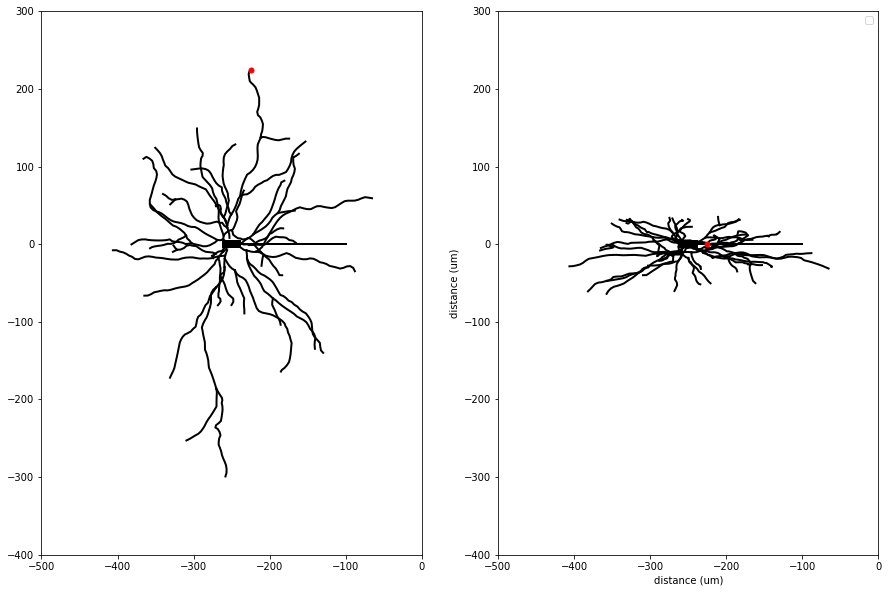

In [6]:
figure(figsize=(15, 10))
#subplot(2,3,4)



# Plot geometry of the cell
for sec in LFPy.cell.neuron.h.allsec():
    idx = cell.get_idx(sec.name())
    ax1=subplot(1,2,1)
    if sec.name()=="soma[0]":
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.zstart[idx], cell.zend[idx][-1]],
            'k',linewidth=8)
    else:
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.zstart[idx], cell.zend[idx][-1]],
            'k',linewidth=2)
        
    ax2=subplot(1,2,2)
    if sec.name()=="soma[0]":
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.ystart[idx], cell.yend[idx][-1]],
            'k',linewidth=8)
    else:
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.ystart[idx], cell.yend[idx][-1]],
            'k',linewidth=2)
# Plot synapses as red dots
for i in np.arange(0,num_syns):
    subplot(1,2,1)
    plot([cell.synapses[i].x], [cell.synapses[i].z], color=[1,0,0], marker='o', markersize=5)
    subplot(1,2,2)
    plot([cell.synapses[i].x], [cell.synapses[i].y], color=[1,0,0], marker='o', markersize=5)
# Plot electrodes as green dots
#plot(electrode.x, electrode.z, '.', marker='o', color='g',label='electrodes')
#for i in np.arange(0,electrode.x.shape[0]):
#    plt.text(electrode.x[i]+10,electrode.z[i]-5,'{}'.format(i))

xlabel('distance (um)')
ylabel('distance (um)')
ax1.set_ylim(-400,300)
ax1.set_xlim(-500,0)
ax2.set_ylim(-400,300)
ax2.set_xlim(-500,0)

legend()

        
#### Calculate extracellular potential by hand
'''
# electrode 5 is at 0,100
h = np.zeros((5,1))
l = np.zeros((5,1))
r = np.zeros((5,1))

for i in np.arange(0,5):
    h[i,0] = electrode.z[5]-cell.zend[i]
    l[i,0] = electrode.z[5]-cell.zstart[i]
    r[i,0] = electrode.x[5]-cell.xstart[i]

dist = np.log((np.sqrt(h**2+r**2)-h)/(np.sqrt(l**2+r**2)-l))
v_ext=1000*(1/(4*np.pi*300*5))*np.dot(np.transpose(cell.imem),dist)
'''


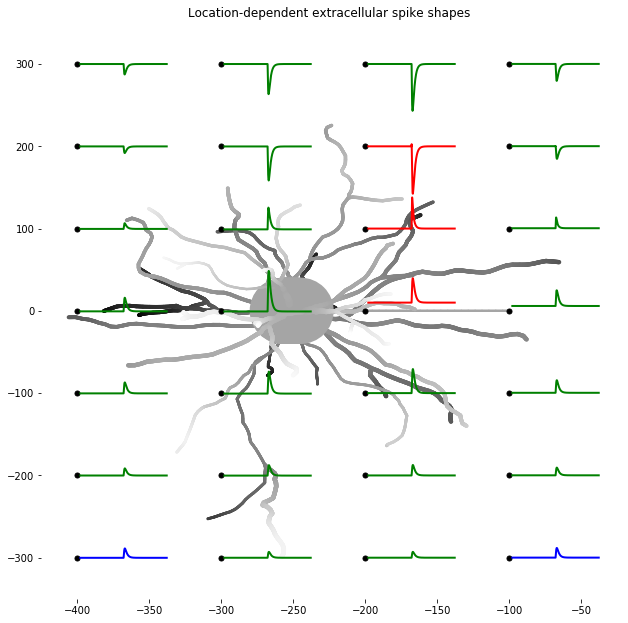

In [7]:
from utils import plot_ex2,plot_elec_grid
fig = plot_elec_grid(cell,electrode)

In [ ]:
fig = plot_ex2(cell, electrode, X, Y, Z, time_show=[50,51,52,53,54,55])
fig.savefig('detailedLFPheatmap.svg')

## Visualize synaptic inputs
Let's get an idea of what the synaptic spike times look like. First we need to convert the spike times to a one dimensional array.

In [ ]:
st_1darr = np.zeros((100000,))

start = 0
stop = syn_spike_times[0].shape[0]
for i in np.arange(0,len(syn_spike_times)-1):
    st_1darr[start:stop] = syn_spike_times[i]
    start = stop
    stop = start + syn_spike_times[i+1].shape[0]

In [ ]:
n_bins = cellParameters['tstop']/10

time = np.arange(0,cellParameters['tstop'],cellParameters['tstop']/n_bins)
figure(figsize=(12,12))
X=np.histogram(st_1darr[st_1darr!=0],bins=n_bins)

for i in np.arange(0,len(syn_spike_times)):    
    subplot(2,1,1)
    plot(syn_spike_times[i],np.tile(i, syn_spike_times[i].shape[0]),'b.')

ylabel('cell ID')
xlabel('time(ms)')
xlim(100,1000)
twinx()

bin_time = (cellParameters['tstop']/n_bins)/1000.0
plot(time,(X[0]/bin_time)/num_syns,'r',label='firing rate')
ylabel('avg. firing rate (Hz)')
legend()
    
from scipy.signal import welch
from scipy.signal.windows import hann

fs = n_bins
nblock = n_bins/4
overlap = 2
win = hann(nblock, True)

f, Pxxf = welch(X[0], fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)

subplot(2,1,2)
semilogy(f,Pxxf)
ylabel('power')
xlabel('frequency (Hz)')

## Extracellular potential traces
We created 21 electrodes. Here we will plot the extracellular potential recorded from them. The large spikes are extracellular action potentials. We then lowpass filter and downsample the signal to 1000 Hz to get the true LFP.

In [ ]:
from scipy import signal
def low_pass_filt(cutoff,fs,data):
    b, a = signal.butter(2, float(cutoff)/float(fs/2), 'low')
    return signal.filtfilt(b, a, data)
 
LFP = np.zeros((electrode.LFP.shape[0],cellParameters['tstop']+1))
    
# Plot the extracellular potential from all of the electrodes in black with the LFP signal in red.
figure(figsize=(17,15))

for i in np.arange(0,electrode.LFP.shape[0]):
    ax=subplot(7,3,i+1)
    plot(cell.tvec,electrode.LFP[i,:],'k')
    y = low_pass_filt(500,16000,electrode.LFP[i,:])
    plot(np.arange(0,cellParameters['tstop']+1,1),y[::16],'r')
    LFP[i,:] = y[::16]
    xlim(1000,1100)


Now to look at the frequency domain. We will first downsample the signal to get rid of the action potentials.

In [ ]:
from scipy.signal import welch
from scipy.signal.windows import hann


fs = 1000
nblock = cellParameters['tstop']
overlap = 100
win = hann(nblock, True)


figure(figsize=(17,15))
print('FFT of LFP')
for i in np.arange(0,electrode.LFP.shape[0]):
    f, Pxxf = welch(LFP[i,:], fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)
    ax=subplot(7,3,i+1)
    semilogy(f,Pxxf)
    xlim(0,200)

#ylim(10e-14,10e-10)
#savefig('FFT.svg')

In [ ]:
fig=figure(figsize=(12,10))
ax1 = plt.subplot(111)
# inset
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(cell.tvec,cell.somav, color='blue')
xlim(2025,2030)
# main plot
ax1.plot(cell.tvec,cell.somav,label='soma',color='blue')
c=0
for x in dendvreclist:
    c = c+1
    y = np.array(x)
    if c==1:
        ax1.plot(cell.tvec,y,label='dend',color=[0,1,0])
        ax2.plot(cell.tvec,y,label='dend',color=[0,1,0])
    else:
        ax1.plot(cell.tvec,y,label='axon',color=[1,0,0])
        ax2.plot(cell.tvec,y,label='axon',color=[1,0,0])
ax1.set_ylim(-72,20)
ax1.legend()
title('mem. potential (mV)')